In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import nn, optim
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
# from training_att import train, test, create_subm
from l5kit.geometry import transform_points
from collections import OrderedDict
from pathlib import Path
import os
# from utils import visualize_trajectory, pytorch_neg_multi_log_likelihood_batch, cfg, setup_experiment, set_seed
import warnings
import matplotlib.pyplot as plt


In [5]:
cur_dir = os.getcwd()
data_path = os.path.dirname(os.path.dirname(cur_dir))+'/dataset/lyft-motion-prediction-autonomous-vehicles'
weight_path = None
model_path = ''

cfg = {
    'format_version': 4,
    "logging": 1,
    'data_path': data_path,
    "device": "cpu",  # at main.py are setted as cfg["device"] =torch.device("cuda:0" if is_available() else "cpu")
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'model_name': "vis_attention",
        'lr': 1e-4,
        'weight_path': weight_path,
        'train': 1,
        "training_validation": 0,
        'predict': 0,
        "to_kaggle": 0,
        "eval_chopped": 0
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },

    'train_data_loader': {
        'key': 'scenes/train_chopped_150/train.zarr',
        'batch_size': 2,
        'shuffle': True,
        'num_workers': 0
    },

    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 8,
        'shuffle': True,
        'num_workers': 2
    },

    'train_params': {
        'max_num_steps': 500001,
        'checkpoint_every_n_steps': 2000,
        "epochs": 150,
    },

    'val_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 8,
        'shuffle': True,
        'num_workers': 2
    },
}

In [6]:
warnings.filterwarnings("ignore")
cur_dir = os.getcwd()
data_path = os.path.dirname(os.path.dirname(cur_dir)) + '/dataset/lyft-motion-prediction-autonomous-vehicles'
model_path = './models/'

class NeighboursHistory:

    def __init__(self, history_agents):
        self.history_agents = history_agents
        self.bs = len(self.history_agents)

    def get_current_poses(self):
        poses = []
        for i in range(self.bs):
            poses.append(self.history_agents[i][0])
        return poses

    def get_history(self):
        poses = []
        for batch in range(self.bs):
            poses.append([self.history_agents[batch][i] for i in range (1, len(self.history_agents[batch]))])
        return poses

class CustomBatch:
    def __init__(self, data):
        transposed_data = list(zip(*data))
        self.semantic_map =torch.stack([torch.tensor(data[i]["image"][-3:,:,:]) for i in range(len(data))], dim=0)
        self.image = torch.stack([torch.tensor(data[i]["image"]) for i in range(len(data))], dim=0)
        self.tgt = torch.stack([torch.tensor(data[i]["target_positions"]) for i in range(len(data))], dim=0)
        self.tgt_avail = torch.stack([torch.tensor(data[i]["target_availabilities"]) for i in range(len(data))], dim=0)
        self.tgt_avail = torch.stack([torch.tensor(data[i]["target_availabilities"]) for i in range(len(data))], dim=0)
        self.world_to_image = torch.stack([torch.tensor(data[i]["world_to_image"]) for i in range(len(data))], dim=0)
        self.raster_from_agent = torch.stack([torch.tensor(data[i]["raster_from_agent"]) for i in range(len(data))],
                                             dim=0)
        self.raster_from_world = torch.stack([torch.tensor(data[i]["raster_from_world"]) for i in range(len(data))],
                                             dim=0)
        self.agent_from_world = torch.stack([torch.tensor(data[i]["agent_from_world"]) for i in range(len(data))],
                                             dim=0)
        self.world_from_agent = torch.stack([torch.tensor(data[i]["world_from_agent"]) for i in range(len(data))], dim=0)

        self.centroid = torch.stack([torch.tensor(data[i]["centroid"]) for i in range(len(data))],
                                            dim=0)
        self.extent = torch.stack([torch.tensor(data[i]["extent"]) for i in range(len(data))],
                                            dim=0)
        self.history_positions = torch.stack([torch.tensor(data[i]["history_positions"]) for i in range(len(data))],
                                            dim=0)
        self.history_agents = NeighboursHistory([(data[i]["history_agents"]) for i in range(len(data))])
        self.yaw = torch.stack([torch.tensor(data[i]["yaw"]) for i in range(len(data))],
                                            dim=0)
        self.speed = torch.stack([torch.tensor(data[i]["speed"]) for i in range(len(data))],
                                            dim=0)

    # custom memory pinning method on custom type

def collate_wrapper(batch):
    return CustomBatch(batch)

# def init_datasets(cfg):
DIR_INPUT = cfg["data_path"]
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer, min_frame_future=10, min_frame_history=0)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"],
                              num_workers=train_cfg["num_workers"], collate_fn=collate_wrapper)
print("==================================TRAIN DATA==================================")
print(train_dataset)

==================================TRAIN DATA==================================
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  2439750   | 192798393  |    23355480   |      67.76      |        150.00        |        79.02         |        15.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


  0%|          | 0/6793848 [00:00<?, ?it/s]

pose in world CS 
 tensor([[-354.7232,  723.3519],
        [ 647.8150, -380.7062]], dtype=torch.float64)

agent to be predicted initial yaw
 tensor([2.3218, 2.2942])

agent to be predicted initial speed
 tensor([15.8342, 13.0418])
local_pose
 tensor([[[-1.1369e-13, -2.8422e-14]],

        [[ 0.0000e+00, -2.8422e-14]]], dtype=torch.float64)

data.semantic_map.shape  torch.Size([2, 3, 224, 224])
[array([[-333.33578491,  715.32086182],
       [-325.07946777,  706.03771973],
       [-346.89471436,  719.9743042 ],
       [-367.37390137,  745.55212402],
       [-328.89736938,  709.86499023],
       [-341.10638428,  718.95281982],
       [-337.29290771,  719.72668457],
       [-313.90518188,  724.67974854],
       [-326.11791992,  740.12579346],
       [-324.02078247,  737.52441406],
       [-316.12207031,  727.45336914],
       [-316.16357422,  740.12420654],
       [-352.32025146,  735.88110352],
       [-400.8684082 ,  778.66625977],
       [-363.58279419,  747.9161377 ],
       [-296.6582

  0%|          | 0/6793848 [00:01<?, ?it/s]


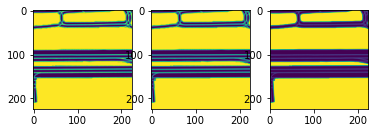

In [9]:
from tqdm import tqdm

for data in tqdm(train_dataloader):
    #agent to be predicted initial pose in world coord system:
    print("pose in world CS \n", data.centroid)
    print()
    print ("agent to be predicted initial yaw\n", data.yaw)
    print()
    print ("agent to be predicted initial speed\n", data.speed) # m/s ?
    #agent to be predicted initial pose in world coord system:
    local_pose = transform_points(data.centroid.unsqueeze(1), data.agent_from_world)
    print("local_pose\n" ,local_pose)
    print()

    
    # semantic map shape:
    print("data.semantic_map.shape ", data.semantic_map.shape)
    # visualize semantic map of first elem
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.imshow(data.semantic_map[0][0])
    ax2.imshow(data.semantic_map[0][1])
    ax3.imshow(data.semantic_map[0][2])
    
    # neighbour starting poses in word coord system!
    print( (data.history_agents.get_current_poses()))
    
    # 10 history poses for each batch.
    # first index - batch_id
    # second index - history forizon (first - 0.1sec back, second - 0.2 sec back ...)
    # in word coord system!
    print(len(data.history_agents.get_history()[0]))
    break
